# Machine Learning applied to TDF Data

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ignore futurewarnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing Machine Learning libraries/tools

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
%matplotlib inline
from sklearn.tree import plot_tree

from sklearn.linear_model import LinearRegression

In [3]:
Results_df = pd.DataFrame(columns=['Models','Train_Score','Test_Score'])
Results_df

,Models,Train_Score,Test_Score


In [4]:
# Import data from CSV file
TDF_GC = pd.read_csv('DATA/TDF_GC_with_rider_metrics.csv')

In [5]:
# Glance at untouched data
TDF_GC.head()

,Rank,Prev_rank,Rider_name,Team_name,Points,Time,Year,Weight(kg),Height(m),Age
0,1,1,POGAČAR Tadej,UAE-Team Emirates,500.0,82:56:36,2021,66.0,1.76,23
1,1,1,POGAČAR Tadej,UAE-Team Emirates,500.0,87:20:05,2020,66.0,1.76,22
2,2,2,VINGEGAARD Jonas,Team Jumbo-Visma,380.0,5:205:20,2021,60.0,1.75,25
3,3,3,CARAPAZ Richard,INEOS Grenadiers,340.0,7:037:03,2021,62.0,1.70,28
4,13,13,CARAPAZ Richard,INEOS Grenadiers,170.0,25:5325:53,2020,62.0,1.70,27


- Dropping Prev_Rank, as its not very usefull for determining overall winener before the race begins as its telling us the ranking before the last stage of TDF
- Dropping Time as its not a feature we will have available before a race, and running classification (not regression) for now

In [6]:
TDF_GC = TDF_GC.drop(['Prev_rank','Time'],axis=1)

In [7]:
# Shape of current data-set
TDF_GC.shape

(1741, 8)

In [8]:
# Checking data type and null values in the data frame
TDF_GC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741 entries, 0 to 1740
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rank        1741 non-null   int64  
 1   Rider_name  1741 non-null   object 
 2   Team_name   1741 non-null   object 
 3   Points      1741 non-null   float64
 4   Year        1741 non-null   int64  
 5   Weight(kg)  1741 non-null   float64
 6   Height(m)   1741 non-null   float64
 7   Age         1741 non-null   int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 108.9+ KB


No Null values.

- `Rank`: What position a rider came in
- `Rider_name`: Name of the cyclist/rider
- `Team_name`: Name of the team the rider rides for
- `Points`: Points based on Rank the rider finished in
- `Time`: Time it took to complete the whole Tour De France (Only winner is absolute, rest are relative)
- `Year`: The Year of the race
- `Weight(kg)`: Weight of the rider in Kilograms
- `Height(m)`: Height of rider in meters
- `Age`: Age of rider the year they competed in years

- `Rank`, `Points`, & `Time` all hold the same information
    - `Rank` every year there may be different number of riders who finish
    - `Points` has 35 unique values and can be used for classification
        - Everyone ranked 35 or lower ends up with 25 points
        - Unique values for everyone from 1 to 34
        - Not sure of the relationship between rank and points awarded
    - `Time` is different every year depending on how long the course is, may not train the model well as winning time for one year might be equivalent of 10th position another year?

## Isolating the overall winners

In [9]:
# Binarizing result, first position = 1, rest = 0
TDF_GC['Winner'] = TDF_GC.Rank.map({1:1})

In [10]:
# Filling the remaining ranks with 0
TDF_GC = TDF_GC.fillna(0)

In [11]:
# Dropping Rank and Points (Potential Target variables) for now.
TDF_GC = TDF_GC.drop(['Rank','Points'],axis=1)

In [12]:
TDF_GC.head()

,Rider_name,Team_name,Year,Weight(kg),Height(m),Age,Winner
0,POGAČAR Tadej,UAE-Team Emirates,2021,66.0,1.76,23,1.0
1,POGAČAR Tadej,UAE-Team Emirates,2020,66.0,1.76,22,1.0
2,VINGEGAARD Jonas,Team Jumbo-Visma,2021,60.0,1.75,25,0.0
3,CARAPAZ Richard,INEOS Grenadiers,2021,62.0,1.70,28,0.0
4,CARAPAZ Richard,INEOS Grenadiers,2020,62.0,1.70,27,0.0


In [13]:
# Checking Data Types
TDF_GC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741 entries, 0 to 1740
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rider_name  1741 non-null   object 
 1   Team_name   1741 non-null   object 
 2   Year        1741 non-null   int64  
 3   Weight(kg)  1741 non-null   float64
 4   Height(m)   1741 non-null   float64
 5   Age         1741 non-null   int64  
 6   Winner      1741 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 95.3+ KB


### Reducing Data Type to save on memory and reduce run time

In [14]:
TDF_GC.Year = TDF_GC.Year.astype('int16')
TDF_GC['Weight(kg)'] = TDF_GC['Weight(kg)'].astype('float16')
TDF_GC['Height(m)'] = TDF_GC['Height(m)'].astype('float32')
TDF_GC.Age = TDF_GC.Age.astype('int8')
TDF_GC.Winner = TDF_GC.Winner.astype('int8')

In [15]:
# Checking the updated data types
TDF_GC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741 entries, 0 to 1740
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rider_name  1741 non-null   object 
 1   Team_name   1741 non-null   object 
 2   Year        1741 non-null   int16  
 3   Weight(kg)  1741 non-null   float16
 4   Height(m)   1741 non-null   float32
 5   Age         1741 non-null   int8   
 6   Winner      1741 non-null   int8   
dtypes: float16(1), float32(1), int16(1), int8(2), object(2)
memory usage: 44.3+ KB


In [16]:
TDF_GC.shape

(1741, 7)

In [17]:
# Converting the Rider_names, which is a categorical column into numeric via one hot encode
pd.get_dummies(TDF_GC.Rider_name)

,ALAPHILIPPE Julian,ALBASINI Michael,AMADOR Andrey,ANACONA Winner,ANTÓN Igor,ARANBURU Alex,ARASHIRO Yukiya,ARCAS Jorge,ARMIRAIL Bruno,ARNDT Nikias,...,ZABEL Rick,ZABRISKIE David,ZAKARIN Ilnur,ZANDIO Xabier,ZEITS Andrey,ZIMMERMANN Georg,ZINGLE Romain,ZUBELDIA Haimar,ĐURASEK Kristijan,ŠTYBAR Zdeněk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Joining the one hot encoded data to our main dataframe
TDF_GC = TDF_GC.join(pd.get_dummies(TDF_GC.Rider_name))

In [19]:
# Checking the shape to ensure change took place properly
TDF_GC.shape

(1741, 655)

In [20]:
# Converting the Team_names, which is a categorical column into numeric via one hot encode
pd.get_dummies(TDF_GC.Team_name)

,AG2R Citroën Team,AG2R La Mondiale,Alpecin-Fenix,Argos - Shimano,Astana - Premier Tech,Astana Pro Team,B&B Hotels - Vital Concept p/b KTM,B&B Hotels p/b KTM,BMC Racing Team,BORA - hansgrohe,...,Team TotalEnergies,Tinkoff,Tinkoff - Saxo,Trek - Segafredo,Trek Factory Racing,UAE Team Emirates,UAE-Team Emirates,Vacansoleil - DCM,Wanty - Gobert Cycling Team,Wanty - Groupe Gobert
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1738,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Joining the one hot encoded data to our main dataframe
TDF_GC = TDF_GC.join(pd.get_dummies(TDF_GC.Team_name))

In [22]:
# Checking the shape to ensure change took place properly
TDF_GC.shape

(1741, 758)

In [23]:
# Dropping the last 2 categorical features
TDF_GC = TDF_GC.drop(['Rider_name','Team_name'],axis=1)
TDF_GC.head()

,Year,Weight(kg),Height(m),Age,Winner,ALAPHILIPPE Julian,ALBASINI Michael,AMADOR Andrey,ANACONA Winner,ANTÓN Igor,...,Team TotalEnergies,Tinkoff,Tinkoff - Saxo,Trek - Segafredo,Trek Factory Racing,UAE Team Emirates,UAE-Team Emirates,Vacansoleil - DCM,Wanty - Gobert Cycling Team,Wanty - Groupe Gobert
0,2021,66.0,1.76,23,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2020,66.0,1.76,22,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2021,60.0,1.75,25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021,62.0,1.70,28,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020,62.0,1.70,27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train/Test Split

Let's see if we can predict the winner of TDF-2021 using data from previous years.

### Training - Data

In [24]:
# Training Data without the target (winner) for every year before 2021
GC_train_data = TDF_GC.drop(['Winner'],axis=1)[TDF_GC.Year != 2021]
GC_train_data.head()

,Year,Weight(kg),Height(m),Age,ALAPHILIPPE Julian,ALBASINI Michael,AMADOR Andrey,ANACONA Winner,ANTÓN Igor,ARANBURU Alex,...,Team TotalEnergies,Tinkoff,Tinkoff - Saxo,Trek - Segafredo,Trek Factory Racing,UAE Team Emirates,UAE-Team Emirates,Vacansoleil - DCM,Wanty - Gobert Cycling Team,Wanty - Groupe Gobert
1,2020,66.0,1.76,22,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2020,62.0,1.70,27,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2016,65.0,1.85,25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2015,65.0,1.85,24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,2020,61.0,1.77,25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Training - Target

In [25]:
# Training Target (winner) for every year before 2021
GC_train_target = TDF_GC.Winner[TDF_GC.Year != 2021]
GC_train_target.head()

1     1
4     0
7     0
8     0
10    0
Name: Winner, dtype: int8

### Training Set Size

In [26]:
# Shape check - Rows should match up
print(GC_train_data.shape)
print(GC_train_target.shape)

(1600, 755)
(1600,)


### Testing - Data

In [27]:
# Testing Data without the target (winner) for 2021
GC_test_data = TDF_GC.drop(['Winner'],axis=1)[TDF_GC.Year == 2021]
GC_test_data.head()

,Year,Weight(kg),Height(m),Age,ALAPHILIPPE Julian,ALBASINI Michael,AMADOR Andrey,ANACONA Winner,ANTÓN Igor,ARANBURU Alex,...,Team TotalEnergies,Tinkoff,Tinkoff - Saxo,Trek - Segafredo,Trek Factory Racing,UAE Team Emirates,UAE-Team Emirates,Vacansoleil - DCM,Wanty - Gobert Cycling Team,Wanty - Groupe Gobert
0,2021,66.0,1.76,23,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2021,60.0,1.75,25,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021,62.0,1.70,28,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2021,67.0,1.88,26,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2021,65.0,1.85,30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Testing - Target

In [28]:
# Testing Target (winner) for 2021
GC_test_target = TDF_GC.Winner[TDF_GC.Year == 2021]
GC_test_target.head()

0    1
2    0
3    0
5    0
6    0
Name: Winner, dtype: int8

### Testing Set Size

In [29]:
# Shape check - Rows should match up
print(GC_test_data.shape)
print(GC_test_target.shape)

(141, 755)
(141,)


In [30]:
# What percentage of the overall data set is our testing data set
GC_test_data.shape[0]/GC_train_data.shape[0] * 100

8.8125

# Logistic Regression

In [31]:
# Fit our Logistic Regression Model to our training data
logreg_model = LogisticRegression(random_state=1).fit(GC_train_data, GC_train_target)

In [32]:
# Predicting the outcomes
model_predictions = logreg_model.predict(GC_test_data)

In [33]:
# Scoring our model on training data
logreg_model.score(GC_train_data, GC_train_target)

0.99375

In [34]:
# Scoring our model on testing data
accuracy_score(model_predictions, GC_test_target)

0.9929078014184397

In [35]:
# Predictions of our test dat set
model_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

All zeroes, this looks bad.

In [36]:
np.unique(model_predictions)

array([0], dtype=int8)

In [37]:
# Adding reults to a scoring dataframe
Results_df.loc[1] = ('Logistic Regression Winner only', logreg_model.score(GC_train_data, GC_train_target), accuracy_score(model_predictions, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
1,Logistic Regression Winner only,0.99375,0.992908


# Support Vector Machines Pipeline

In [38]:
# Creating a SVM Pipeline with standard scaling
SVM_pipe = Pipeline(
    [('normalise', StandardScaler()),
    ('svm', svm.SVC(kernel='rbf'))]
)

In [39]:
# Fitting our SVM model to the training data
SVM_pipe.fit(GC_train_data, GC_train_target)

Pipeline(steps=[('normalise', StandardScaler()), ('svm', SVC())])

In [40]:
# Scoring our model on training data
SVM_pipe.score(GC_train_data, GC_train_target)

0.995

In [41]:
# Scoring our model on testing data
SVM_pipe.score(GC_test_data, GC_test_target)

0.9929078014184397

In [42]:
# Predicting outcomes
model_predictions_svm = SVM_pipe.predict(GC_test_data)

In [43]:
# Predictions of our test dat set
model_predictions_svm

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

All zeroes again, seems to be a trend with this method.

In [44]:
# Adding reults to a scoring dataframe
Results_df.loc[2] = ('SVM Winner only', SVM_pipe.score(GC_train_data, GC_train_target) , SVM_pipe.score(GC_test_data, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
1,Logistic Regression Winner only,0.99375,0.992908
2,SVM Winner only,0.99500,0.992908


# K Nearest Neighbours

In [45]:
# Creating a KNN Pipeline
KNN_pipe = Pipeline([
    ('scale', StandardScaler()),
    ("feature_selector", SelectKBest()),
    ('KNN', KNeighborsClassifier())
])

In [46]:
# Cross-validation score on the training set
cross_val_score(KNN_pipe, GC_train_data, GC_train_target).mean()

0.99375

In [47]:
# Fitting the KNN to our training data set
KNN_pipe.fit(GC_train_data, GC_train_target)

Pipeline(steps=[('scale', StandardScaler()),
                ('feature_selector', SelectKBest()),
                ('KNN', KNeighborsClassifier())])

In [48]:
# Scoring our model on training data
KNN_pipe.score(GC_train_data, GC_train_target)

0.995

In [49]:
# Scoring our model on testing data
KNN_pipe.score(GC_test_data, GC_test_target)

0.9858156028368794

In [50]:
# Adding reults to a scoring dataframe
Results_df.loc[3] = ('KNN Winner only', KNN_pipe.score(GC_train_data, GC_train_target) , KNN_pipe.score(GC_test_data, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
1,Logistic Regression Winner only,0.99375,0.992908
2,SVM Winner only,0.99500,0.992908
3,KNN Winner only,0.99500,0.985816


# Decision Tree

In [51]:
# Instantiating the Decision Tree model
DT = DecisionTreeClassifier()
# Fitting the Decision Tree model to our training data
DT.fit(GC_train_data, GC_train_target)

DecisionTreeClassifier()

In [52]:
# Scoring our model on training data
DT.score(GC_train_data, GC_train_target)

1.0

In [53]:
# Scoring our model on testing data
DT.score(GC_test_data, GC_test_target)

1.0

In [54]:
# Model Predictions
model_predictions_DT = DT.predict(GC_test_data)

In [55]:
# Model Predictions
model_predictions_DT

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [56]:
# Adding reults to a scoring dataframe
Results_df.loc[4] = ('Decision Tree Winner only', DT.score(GC_train_data, GC_train_target) , DT.score(GC_test_data, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
1,Logistic Regression Winner only,0.99375,0.992908
2,SVM Winner only,0.99500,0.992908
3,KNN Winner only,0.99500,0.985816
4,Decision Tree Winner only,1.00000,1.000000


### Plotting the Decision Tree

In [57]:
def PlotBoundaries(model, X, Y, dot_size=20, figsize=(10,7)) :
    '''
    Helper function that plots the decision boundaries of a model and data (X,Y)
    code modified from: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    '''
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1,X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=figsize)
    plt.contourf(xx, yy, Z, alpha=0.4)

    #Plot
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=dot_size, edgecolor='k')
    plt.show()

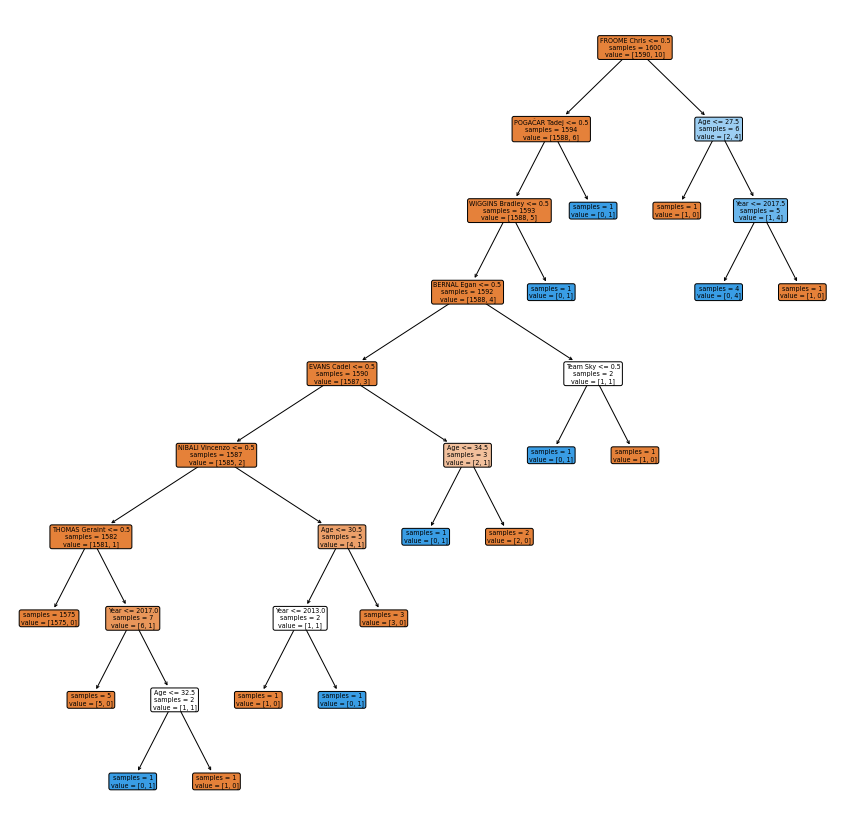

In [58]:
plt.figure(figsize=(15,15))

plot_tree(DT, 
          feature_names=GC_train_data.columns, 
          #class_names=["Approved", "Denied", "In Review"],
          rounded=True,
          impurity=False,
          filled=True,
         )
plt.show()

It seems like using a binary classifier that only predicts the winner is a bad call. The model scores well because it can easily label everyone as a loser and come out ahead. The distribution of our classes is very very poor when trying to only find the overall winner using classification models. While Decision Tree does give us a winner, the model is clearly overfitted.

Let's try a different approach for classification, one where the distribution is a bit more spread out.

# Using Points instead of just winner

In [59]:
# Import data from CSV file
TDF_GC = pd.read_csv('DATA/TDF_GC_with_rider_metrics.csv')
TDF_GC.shape

(1741, 10)

In [60]:
# Glancing at the data
TDF_GC.head()

,Rank,Prev_rank,Rider_name,Team_name,Points,Time,Year,Weight(kg),Height(m),Age
0,1,1,POGAČAR Tadej,UAE-Team Emirates,500.0,82:56:36,2021,66.0,1.76,23
1,1,1,POGAČAR Tadej,UAE-Team Emirates,500.0,87:20:05,2020,66.0,1.76,22
2,2,2,VINGEGAARD Jonas,Team Jumbo-Visma,380.0,5:205:20,2021,60.0,1.75,25
3,3,3,CARAPAZ Richard,INEOS Grenadiers,340.0,7:037:03,2021,62.0,1.70,28
4,13,13,CARAPAZ Richard,INEOS Grenadiers,170.0,25:5325:53,2020,62.0,1.70,27


In [61]:
# Dropping Rank, Prev_rank, and Time as they're targets we're not interested in at this moment
TDF_GC = TDF_GC.drop(['Rank','Prev_rank','Time'],axis=1)
TDF_GC.shape

(1741, 7)

In [62]:
# Checking data types and null values
TDF_GC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741 entries, 0 to 1740
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rider_name  1741 non-null   object 
 1   Team_name   1741 non-null   object 
 2   Points      1741 non-null   float64
 3   Year        1741 non-null   int64  
 4   Weight(kg)  1741 non-null   float64
 5   Height(m)   1741 non-null   float64
 6   Age         1741 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 95.3+ KB


### Changing data types to reduce memory use and run time

In [63]:
TDF_GC.Year = TDF_GC.Year.astype('int16')
TDF_GC['Weight(kg)'] = TDF_GC['Weight(kg)'].astype('float16')
TDF_GC['Height(m)'] = TDF_GC['Height(m)'].astype('float32')
TDF_GC.Age = TDF_GC.Age.astype('int8')
TDF_GC.Points = TDF_GC.Points.astype('int16')

In [64]:
# Checking if the change took place
TDF_GC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741 entries, 0 to 1740
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rider_name  1741 non-null   object 
 1   Team_name   1741 non-null   object 
 2   Points      1741 non-null   int16  
 3   Year        1741 non-null   int16  
 4   Weight(kg)  1741 non-null   float16
 5   Height(m)   1741 non-null   float32
 6   Age         1741 non-null   int8   
dtypes: float16(1), float32(1), int16(2), int8(1), object(2)
memory usage: 46.0+ KB


In [65]:
TDF_GC.head()

,Rider_name,Team_name,Points,Year,Weight(kg),Height(m),Age
0,POGAČAR Tadej,UAE-Team Emirates,500,2021,66.0,1.76,23
1,POGAČAR Tadej,UAE-Team Emirates,500,2020,66.0,1.76,22
2,VINGEGAARD Jonas,Team Jumbo-Visma,380,2021,60.0,1.75,25
3,CARAPAZ Richard,INEOS Grenadiers,340,2021,62.0,1.70,28
4,CARAPAZ Richard,INEOS Grenadiers,170,2020,62.0,1.70,27


In [66]:
# One hot encoding rider names
TDF_GC = TDF_GC.join(pd.get_dummies(TDF_GC.Rider_name))
TDF_GC.shape

(1741, 655)

In [67]:
# One hot encoding team names
TDF_GC = TDF_GC.join(pd.get_dummies(TDF_GC.Team_name))
TDF_GC.shape

(1741, 758)

In [68]:
# Dropping the last 2 categorical columns
TDF_GC = TDF_GC.drop(['Rider_name','Team_name'],axis=1)
TDF_GC.shape

(1741, 756)

In [69]:
TDF_GC.head()

,Points,Year,Weight(kg),Height(m),Age,ALAPHILIPPE Julian,ALBASINI Michael,AMADOR Andrey,ANACONA Winner,ANTÓN Igor,...,Team TotalEnergies,Tinkoff,Tinkoff - Saxo,Trek - Segafredo,Trek Factory Racing,UAE Team Emirates,UAE-Team Emirates,Vacansoleil - DCM,Wanty - Gobert Cycling Team,Wanty - Groupe Gobert
0,500,2021,66.0,1.76,23,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,500,2020,66.0,1.76,22,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,380,2021,60.0,1.75,25,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,340,2021,62.0,1.70,28,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,170,2020,62.0,1.70,27,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# Dropping the year column
TDF_GC = TDF_GC.drop(['Year'],axis=1)
TDF_GC.shape

(1741, 755)

## Train/Test Split

In [71]:
# Splitting Dataset into Data(Features) and Target
Data = TDF_GC.drop(['Points'],axis=1)
Target = TDF_GC.Points

In [72]:
# Taking a random 20% chunk for our test set, making sure to stratify our target
GC_rem_data, GC_test_data, GC_rem_target, GC_test_target = \
    train_test_split(Data, Target, test_size = 0.2, random_state=1, stratify=Target)

In [73]:
# Splitting the remainder in two chunks for training and validation (70% of remainder for training)
GC_train_data, GC_val_data, GC_train_target, GC_val_target = \
    train_test_split(GC_rem_data, GC_rem_target, test_size = 0.3, random_state=1, stratify=GC_rem_target)

## Logistic Regression - Hyperparamter Optimization

In [74]:
# Optimizing our Hyperparameters to get the best results
validation_scores = []
train_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    my_logreg = LogisticRegression(C = c,random_state=1)
    my_logreg.fit(GC_train_data,GC_train_target)
    
    # train on traning set
    train_scores.append(my_logreg.score(GC_train_data,GC_train_target))
    # score on validation set
    validation_scores.append(my_logreg.score(GC_val_data,GC_val_target))

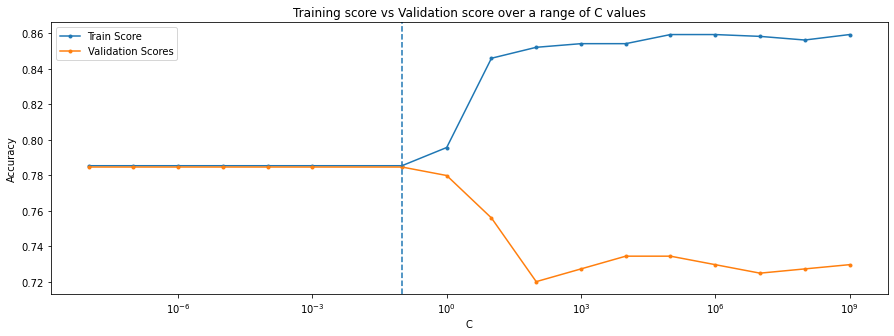

In [75]:
# Plotting the training and validation scores
plt.figure(figsize=(15,5))
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.title('Training score vs Validation score over a range of C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.axvline(0.1, linestyle = '--')
plt.legend()
plt.show()

In [76]:
# Instatiate with optimal hyperparameters
log_reg = LogisticRegression(C=0.1,random_state=1)

# Fitting the model to the complete train/validate set
log_reg.fit(GC_rem_data, GC_rem_target)
log_reg.score(GC_test_data,GC_test_target)

0.7851002865329513

In [77]:
# Prediciting our test set
model_predictions = log_reg.predict(GC_test_data)

In [78]:
# Looking at the predictions
model_predictions

array([25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25

Again it predicts every rider to come below 34th rank, and artifically gets a high score

In [79]:
# Adding reults to a scoring dataframe
Results_df.loc[5] = ('Logistic Regression with H.O. & Points', log_reg.score(GC_rem_data, GC_rem_target) , log_reg.score(GC_test_data, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
1,Logistic Regression Winner only,0.993750,0.992908
2,SVM Winner only,0.995000,0.992908
3,KNN Winner only,0.995000,0.985816
4,Decision Tree Winner only,1.000000,1.000000
5,Logistic Regression with H.O. & Points,0.785201,0.785100


## K Nearest Neighbours - Hyperparameter Optimization

In [80]:
# The different K values to try out and save to 'neighbors'
neighbors = range(1, 50, 1)

# Empty lists to append the accuracies to 
train = []
validate = []

# Loop through neighbors
for K in neighbors:
    
    # Instantiate the model 
    KNN = KNeighborsClassifier(n_neighbors=K)
    
    # Fit the model 
    KNN.fit(GC_train_data, GC_train_target)
    
    # Score the model 
    train.append(KNN.score(GC_train_data, GC_train_target))
    validate.append(KNN.score(GC_val_data, GC_val_target))

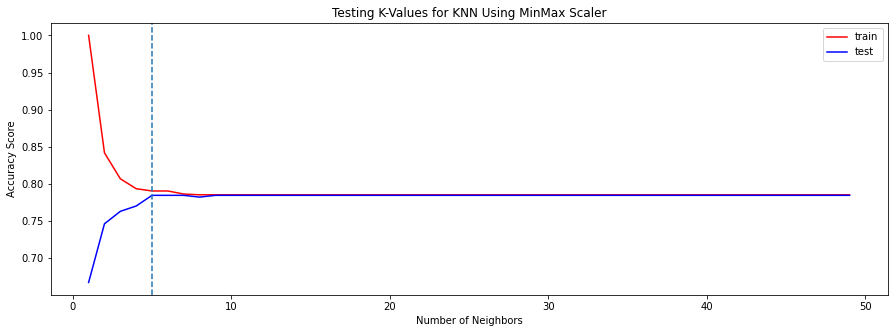

In [81]:
# Plot the accuracy scores
plt.figure(figsize=(15,5))
plt.plot(neighbors, train, c='red', label='train')
plt.plot(neighbors, validate, c='blue', label='test')
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy Score")
plt.title('Testing K-Values for KNN Using MinMax Scaler')
plt.axvline(5, linestyle = '--')
plt.legend()
plt.show()

In [82]:
# Fitting our KNN model with optimized hyperparameters to the full train/validation set
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(GC_rem_data, GC_rem_target)

KNeighborsClassifier()

In [83]:
# Scoring our model on the test set
KNN.score(GC_test_data, GC_test_target)

0.7851002865329513

In [84]:
# Adding reults to a scoring dataframe
Results_df.loc[6] = ('KNN with H.O. & Points', KNN.score(GC_rem_data, GC_rem_target) , KNN.score(GC_test_data, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
1,Logistic Regression Winner only,0.993750,0.992908
2,SVM Winner only,0.995000,0.992908
3,KNN Winner only,0.995000,0.985816
4,Decision Tree Winner only,1.000000,1.000000
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.788075,0.785100


## Decision Tree - Hyperparameter Optimization

In [85]:
# A list of the maximum depths to try out
depths = range(1, int(np.sqrt(GC_train_data.shape[0])))

In [86]:
# Empty lists to append to
train_DT = []
validate_DT = []

# Loop through the depths
for max_depth in depths:
    
    # Instantiate the model 
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=11)
    
    # Fit the model 
    DT.fit(GC_train_data, GC_train_target)
    
    # Score the model 
    train_DT.append(DT.score(GC_train_data, GC_train_target))
    validate_DT.append(DT.score(GC_val_data, GC_val_target))

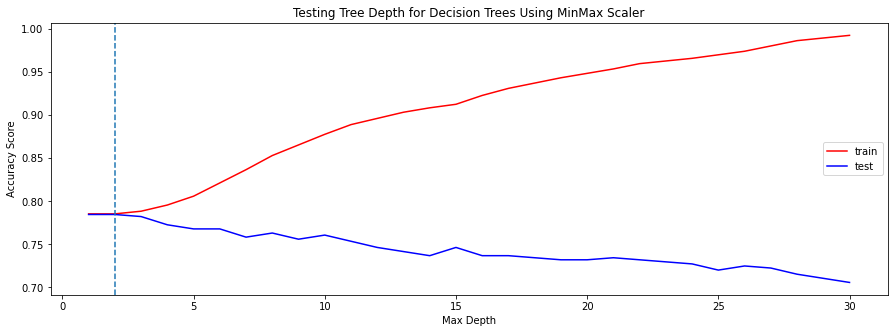

In [87]:
# Plotting the accuracy scores
plt.figure(figsize=(15,5))
plt.plot(depths, train_DT, c='red', label='train')
plt.plot(depths, validate_DT, c='blue', label='test')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title('Testing Tree Depth for Decision Trees Using MinMax Scaler')
plt.axvline(2, linestyle = '--')
plt.legend()
plt.show()

In [88]:
# Instantiating the model with optimized hyper parameters
DT = DecisionTreeClassifier(max_depth=2, random_state=42)

# Fit the model 
DT.fit(GC_rem_data, GC_rem_target)

# Store accuracy scores on full training set and test set
DT_train = DT.score(GC_rem_data, GC_rem_target)
DT_test = DT.score(GC_test_data, GC_test_target)

# Score the model 
print(f"Train Accuracy: {DT_train}")
print(f"Test Accuracy: {DT_test}")

Train Accuracy: 0.7852011494252874
Test Accuracy: 0.7851002865329513


In [89]:
# Adding reults to a scoring dataframe
Results_df.loc[7] = ('Decission Tree with H.O. & Points', DT.score(GC_rem_data, GC_rem_target) , DT.score(GC_test_data, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
1,Logistic Regression Winner only,0.993750,0.992908
2,SVM Winner only,0.995000,0.992908
3,KNN Winner only,0.995000,0.985816
4,Decision Tree Winner only,1.000000,1.000000
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.788075,0.785100
7,Decission Tree with H.O. & Points,0.785201,0.785100


## Support Vector Machines - Hyperparameter Optimization

In [90]:
# Trying to optimize hyper parameters for SVM, even though its tricky

validation_scores_svm = []
train_scores_svm = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    SVM = LinearSVC(C = c, random_state=1)
    SVM.fit(GC_train_data, GC_train_target)
    
    # train on traning set
    train_scores_svm.append(SVM.score(GC_train_data,GC_train_target))
    # score on validation set
    validation_scores_svm.append(SVM.score(GC_val_data,GC_val_target))

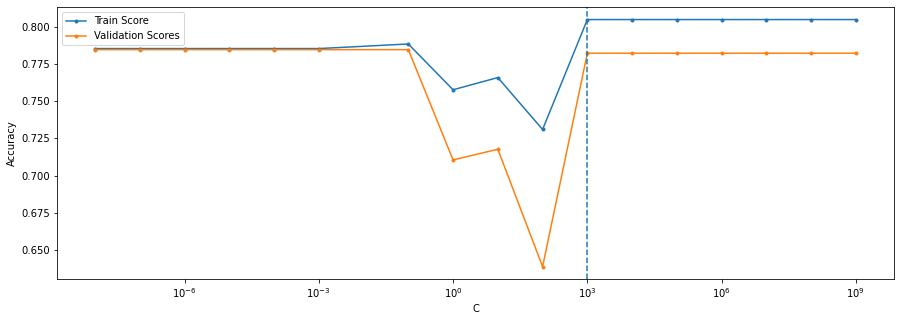

In [91]:
# Plotting the SVM scores over a range of c values
plt.figure(figsize=(15,5))
plt.plot(C_range, train_scores_svm,label="Train Score",marker='.')
plt.plot(C_range, validation_scores_svm,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.axvline(1000, linestyle = '--')
plt.legend()
plt.show();

In [92]:
# Fitting our SVM model to the complete training/validation set
SVM = LinearSVC(C=1000,random_state=1)
SVM.fit(GC_rem_data,GC_rem_target)

LinearSVC(C=1000, random_state=1)

In [93]:
# Printing the scores
print(f"The TRAIN classification accuracy is: {SVM.score(GC_rem_data,GC_rem_target)}")
print(f"The TEST classification accuracy is: {SVM.score(GC_test_data, GC_test_target)}")

The TRAIN classification accuracy is: 0.7952586206896551
The TEST classification accuracy is: 0.7851002865329513


In [94]:
# Adding reults to a scoring dataframe
Results_df.loc[8] = ('SVM with H.O. & Points', SVM.score(GC_rem_data, GC_rem_target) , SVM.score(GC_test_data, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
1,Logistic Regression Winner only,0.993750,0.992908
2,SVM Winner only,0.995000,0.992908
3,KNN Winner only,0.995000,0.985816
4,Decision Tree Winner only,1.000000,1.000000
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.788075,0.785100
7,Decission Tree with H.O. & Points,0.785201,0.785100
8,SVM with H.O. & Points,0.795259,0.785100


# Principal Component Analysis

In [95]:
# Insantiate
my_PCA = PCA()
# Fit the PCA object to the data
my_PCA.fit(GC_train_data)

PCA()

In [96]:
# Transform the original data.
GC_train_data_PCA = my_PCA.transform(GC_train_data)
GC_val_data_PCA = my_PCA.transform(GC_val_data)
GC_rem_data_PCA = my_PCA.transform(GC_rem_data)
GC_test_data_PCA = my_PCA.transform(GC_test_data)

## PCA - Logistic Regression with Hyperparameter Optimization

In [97]:
# Hyperparamter Optimization with PCA Data
validation_scores = []
train_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    my_logreg = LogisticRegression(C = c,random_state=1)
    my_logreg.fit(GC_train_data_PCA, GC_train_target)
    
    # train on traning set
    train_scores.append(my_logreg.score(GC_train_data_PCA, GC_train_target))
    # score on validation set
    validation_scores.append(my_logreg.score(GC_val_data_PCA, GC_val_target))

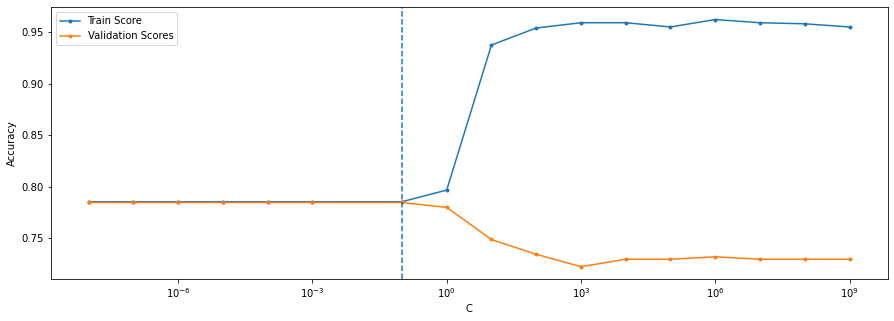

In [98]:
# Plotting the scores
plt.figure(figsize=(15,5))
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.axvline(0.1, linestyle = '--')
plt.legend()
plt.show();

In [99]:
# Instantiate with optimal hyperparameters
my_logreg = LogisticRegression(C=0.1,random_state=1)

# Fitting the model to complete train/validate data
my_logreg.fit(GC_rem_data_PCA, GC_rem_target)
my_logreg.score(GC_test_data_PCA, GC_test_target)

0.7851002865329513

In [100]:
# Adding reults to a scoring dataframe
Results_df.loc[9] = ('Logistic Regression with PCA & Points', my_logreg.score(GC_rem_data_PCA, GC_rem_target) , my_logreg.score(GC_test_data_PCA, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
1,Logistic Regression Winner only,0.993750,0.992908
2,SVM Winner only,0.995000,0.992908
3,KNN Winner only,0.995000,0.985816
4,Decision Tree Winner only,1.000000,1.000000
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.788075,0.785100
7,Decission Tree with H.O. & Points,0.785201,0.785100
8,SVM with H.O. & Points,0.795259,0.785100
9,Logistic Regression with PCA & Points,0.785201,0.785100


## PCA - KNN - Hyperparameter Optimization

In [101]:
# The different K values to try out and save to 'neighbors'
neighbors = range(1, 50, 1)

# Empty lists to append the accuracies to 
train = []
validate = []

# Loop through neighbors
for K in neighbors:
    
    # Instantiate the model 
    KNN = KNeighborsClassifier(n_neighbors=K)
    
    # Fit the model 
    KNN.fit(GC_train_data_PCA, GC_train_target)
    
    # Score the model 
    train.append(KNN.score(GC_train_data_PCA, GC_train_target))
    validate.append(KNN.score(GC_val_data_PCA, GC_val_target))

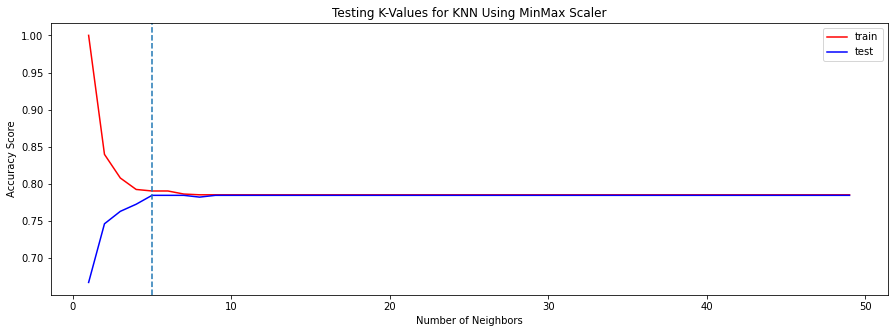

In [102]:
# Plot the accuracies 
plt.figure(figsize=(15,5))
plt.plot(neighbors, train, c='red', label='train')
plt.plot(neighbors, validate, c='blue', label='test')
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy Score")
plt.title('Testing K-Values for KNN Using MinMax Scaler')
plt.axvline(5, linestyle = '--')
plt.legend()
plt.show()

In [103]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(GC_rem_data_PCA, GC_rem_target)

KNeighborsClassifier()

In [104]:
KNN.score(GC_test_data_PCA, GC_test_target)

0.7851002865329513

In [105]:
# Adding reults to a scoring dataframe
Results_df.loc[10] = ('KNN with PCA & Points', KNN.score(GC_rem_data_PCA, GC_rem_target) , KNN.score(GC_test_data_PCA, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
1,Logistic Regression Winner only,0.993750,0.992908
2,SVM Winner only,0.995000,0.992908
3,KNN Winner only,0.995000,0.985816
4,Decision Tree Winner only,1.000000,1.000000
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.788075,0.785100
7,Decission Tree with H.O. & Points,0.785201,0.785100
8,SVM with H.O. & Points,0.795259,0.785100
9,Logistic Regression with PCA & Points,0.785201,0.785100
10,KNN with PCA & Points,0.788793,0.785100


## PCA - Decision Tree - Hyperparameter Optimization

In [106]:
# A list of the maximum depths to try out and save to 'depths'
depths = range(1, int(np.sqrt(GC_train_data_PCA.shape[0])))

In [107]:
# Empty lists to append to
train_DT = []
validate_DT = []

# Loop through the depths
for max_depth in depths:
    
    # Instantiate the model 
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=11)
    
    # Fit the model 
    DT.fit(GC_train_data_PCA, GC_train_target)
    
    # Score the model 
    train_DT.append(DT.score(GC_train_data_PCA, GC_train_target))
    validate_DT.append(DT.score(GC_val_data_PCA, GC_val_target))

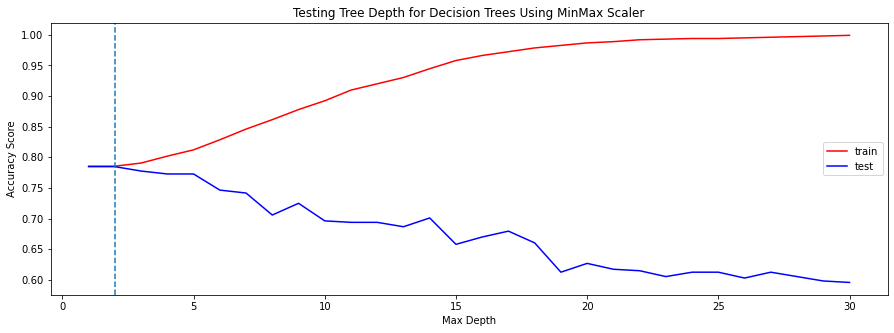

In [108]:
# Plotting the accuracies
plt.figure(figsize=(15,5))
plt.plot(depths, train_DT, c='red', label='train')
plt.plot(depths, validate_DT, c='blue', label='test')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title('Testing Tree Depth for Decision Trees Using MinMax Scaler')
plt.axvline(2, linestyle = '--')
plt.legend()
plt.show()

In [109]:
# Instantiate Decision Tree model with optimal hyperparameters
DT = DecisionTreeClassifier(max_depth=2, random_state=11)

# Fit the model 
DT.fit(GC_rem_data_PCA, GC_rem_target)

# Store accuracy scores
DT_train = DT.score(GC_rem_data_PCA, GC_rem_target)
DT_test = DT.score(GC_test_data_PCA, GC_test_target)

# Score the model 
print(f"Train Accuracy: {DT_train}")
print(f"Test Accuracy: {DT_test}")

Train Accuracy: 0.7852011494252874
Test Accuracy: 0.7851002865329513


In [110]:
# Adding reults to a scoring dataframe
Results_df.loc[11] = ('DT with PCA & Points', DT.score(GC_rem_data_PCA, GC_rem_target) , DT.score(GC_test_data_PCA, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
1,Logistic Regression Winner only,0.993750,0.992908
2,SVM Winner only,0.995000,0.992908
3,KNN Winner only,0.995000,0.985816
4,Decision Tree Winner only,1.000000,1.000000
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.788075,0.785100
7,Decission Tree with H.O. & Points,0.785201,0.785100
8,SVM with H.O. & Points,0.795259,0.785100
9,Logistic Regression with PCA & Points,0.785201,0.785100
10,KNN with PCA & Points,0.788793,0.785100


# Results from all Models

In [111]:
Results_df

,Models,Train_Score,Test_Score
1,Logistic Regression Winner only,0.993750,0.992908
2,SVM Winner only,0.995000,0.992908
3,KNN Winner only,0.995000,0.985816
4,Decision Tree Winner only,1.000000,1.000000
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.788075,0.785100
7,Decission Tree with H.O. & Points,0.785201,0.785100
8,SVM with H.O. & Points,0.795259,0.785100
9,Logistic Regression with PCA & Points,0.785201,0.785100
10,KNN with PCA & Points,0.788793,0.785100


Seems like Classification might not be the best for determining the winner of TDF as there is a class imbalance. Let's try regression.

# Linear Regression

In [112]:
# Import data from CSV file
TDF_GC = pd.read_csv('DATA/TDF_GC_with_rider_metrics.csv')
# Glance at untouched data
TDF_GC.head()

,Rank,Prev_rank,Rider_name,Team_name,Points,Time,Year,Weight(kg),Height(m),Age
0,1,1,POGAČAR Tadej,UAE-Team Emirates,500.0,82:56:36,2021,66.0,1.76,23
1,1,1,POGAČAR Tadej,UAE-Team Emirates,500.0,87:20:05,2020,66.0,1.76,22
2,2,2,VINGEGAARD Jonas,Team Jumbo-Visma,380.0,5:205:20,2021,60.0,1.75,25
3,3,3,CARAPAZ Richard,INEOS Grenadiers,340.0,7:037:03,2021,62.0,1.70,28
4,13,13,CARAPAZ Richard,INEOS Grenadiers,170.0,25:5325:53,2020,62.0,1.70,27


In [113]:
# Dropping targets we're not interested in
TDF_GC = TDF_GC.drop(['Prev_rank','Time','Points'],axis=1)
TDF_GC.head()

,Rank,Rider_name,Team_name,Year,Weight(kg),Height(m),Age
0,1,POGAČAR Tadej,UAE-Team Emirates,2021,66.0,1.76,23
1,1,POGAČAR Tadej,UAE-Team Emirates,2020,66.0,1.76,22
2,2,VINGEGAARD Jonas,Team Jumbo-Visma,2021,60.0,1.75,25
3,3,CARAPAZ Richard,INEOS Grenadiers,2021,62.0,1.70,28
4,13,CARAPAZ Richard,INEOS Grenadiers,2020,62.0,1.70,27


In [114]:
# Checking data types and Null values
TDF_GC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741 entries, 0 to 1740
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rank        1741 non-null   int64  
 1   Rider_name  1741 non-null   object 
 2   Team_name   1741 non-null   object 
 3   Year        1741 non-null   int64  
 4   Weight(kg)  1741 non-null   float64
 5   Height(m)   1741 non-null   float64
 6   Age         1741 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 95.3+ KB


In [115]:
# TDF_GC.Year = TDF_GC.Year.astype('int16')
TDF_GC['Weight(kg)'] = TDF_GC['Weight(kg)'].astype('float16')
TDF_GC['Height(m)'] = TDF_GC['Height(m)'].astype('float32')
TDF_GC.Age = TDF_GC.Age.astype('int8')
TDF_GC.Rank = TDF_GC.Rank.astype('int16')

In [116]:
# Checking data type change
TDF_GC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741 entries, 0 to 1740
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rank        1741 non-null   int16  
 1   Rider_name  1741 non-null   object 
 2   Team_name   1741 non-null   object 
 3   Year        1741 non-null   int64  
 4   Weight(kg)  1741 non-null   float16
 5   Height(m)   1741 non-null   float32
 6   Age         1741 non-null   int8   
dtypes: float16(1), float32(1), int16(1), int64(1), int8(1), object(2)
memory usage: 56.2+ KB


In [117]:
# One hot encoding rider names
TDF_GC = TDF_GC.join(pd.get_dummies(TDF_GC.Rider_name))
TDF_GC.shape

(1741, 655)

In [118]:
# One hot encoding team names
TDF_GC = TDF_GC.join(pd.get_dummies(TDF_GC.Team_name))
TDF_GC.shape

(1741, 758)

In [119]:
# Dropping the last 2 categorical columns
TDF_GC = TDF_GC.drop(['Rider_name','Team_name'],axis=1)
TDF_GC.shape

(1741, 756)

## Train/Test Split

### Training Set

In [120]:
# Training Data without the target (winner) for every year before 2021
GC_train_data = TDF_GC.drop(['Rank'],axis=1)[TDF_GC.Year != 2021]

# Training Target (winner) for every year before 2021
GC_train_target = TDF_GC.Rank[TDF_GC.Year != 2021]

In [121]:
# Shape check - Rows should match up
print(GC_train_data.shape)
print(GC_train_target.shape)

(1600, 755)
(1600,)


### Testing Set

In [122]:
# Testing Data without the target (winner) for 2021
GC_test_data = TDF_GC.drop(['Rank'],axis=1)[TDF_GC.Year == 2021]

# Testing Target (winner) for 2021
GC_test_target = TDF_GC.Rank[TDF_GC.Year == 2021]

In [123]:
# Shape check - Rows should match up
print(GC_test_data.shape)
print(GC_test_target.shape)

(141, 755)
(141,)


In [124]:
GC_train_data = GC_train_data.drop(['Year'],axis=1)
GC_test_data = GC_test_data.drop(['Year'],axis=1)

print(GC_train_data.shape)
print(GC_test_data.shape)

(1600, 754)
(141, 754)


## Linear Regression Model

In [125]:
# Fitting out Linear Regression model to the training data
lin_reg = LinearRegression().fit(GC_train_data, GC_train_target)

In [126]:
# Scoring the Linear Regression model on the training set
lin_reg.score(GC_train_data, GC_train_target)

0.872663514051133

In [127]:
# Scoring the Linear Regression model on the testing set
lin_reg.score(GC_test_data, GC_test_target)

0.4356749901523548

In [128]:
Results_df.loc[12] = ('Linear Regression 1', lin_reg.score(GC_train_data, GC_train_target) , lin_reg.score(GC_test_data, GC_test_target))
Results_df

,Models,Train_Score,Test_Score
1,Logistic Regression Winner only,0.993750,0.992908
2,SVM Winner only,0.995000,0.992908
3,KNN Winner only,0.995000,0.985816
4,Decision Tree Winner only,1.000000,1.000000
5,Logistic Regression with H.O. & Points,0.785201,0.785100
6,KNN with H.O. & Points,0.788075,0.785100
7,Decission Tree with H.O. & Points,0.785201,0.785100
8,SVM with H.O. & Points,0.795259,0.785100
9,Logistic Regression with PCA & Points,0.785201,0.785100
10,KNN with PCA & Points,0.788793,0.785100


### Let's try a different train/test split to see if we can improve out testing score

In [129]:
# Dropping all rider who finished below 100 for balancing our classes
TDF_GC_2 = TDF_GC[TDF_GC.Rank <= 100]

In [130]:
# Splitting Dataset into Data(Features) and Target
Data = TDF_GC_2.drop(['Rank'],axis=1)
Target = TDF_GC_2.Rank

In [131]:
# Taking a random 20% chunk for our test set, making sure to stratify our target
GC_train_data, GC_test_data, GC_train_target, GC_test_target = \
    train_test_split(Data, Target, test_size = 0.2, random_state=1, stratify=Target)

## Linear Regression Model second attempt

In [132]:
# Fitting out Linear Regression model to the training data
lin_reg = LinearRegression().fit(GC_train_data, GC_train_target)

In [133]:
# Scoring the Linear Regression model on the training set
lin_reg.score(GC_train_data, GC_train_target)

0.834825820405608

In [134]:
# Scoring the Linear Regression model on the testing set
lin_reg.score(GC_test_data, GC_test_target)

-1.2400605837213825e+22

It seems that our Linear Regression model can train well on our data, but when tested against the testing set, it can only manage about 43.5% accuracy, which is about as good as coin toss. The modeling requires further work to generate better results.